# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Purpose
The data contains data on the price of the used cars with features when they were sold. The objective is to find out the "reason" or the features that statistically contributed to the target feature (price of the use car). Since the target is a continuous feature, this will be a regression problem which we will be using simple linear regression as a start and compare with different regression model with various hyperparameter (hyper-paramter tunning)

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [19]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, SelectKBest, SelectPercentile,f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
set_config(display="diagram")
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher


In [2]:
df=pd.read_csv('data/vehicles.csv')
df.head()


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [3]:
# check on unique value in all columns
df.nunique()

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

#### base on the unique value of each columns, we separate categorical features into two groups:
##### Low-cardinality and High-cardinality with differnet encoding method


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [4]:
df=df.drop(['id', 'VIN'], axis=1)
low_card=['condition','cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size']
high_card=['region', 'manufacturer', 'model', 'type', 'paint_color', 'state']

In [5]:
# Experimentation
# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer, StandardScaler

# num_imputers = [] 
# num_imputers2 = [] 
# num_imputers.append(("impute_mean", SimpleImputer(), ["odometer"]))
# num_imputers2.append(("impute_mode", SimpleImputer(strategy='most_frequent'), ['year']))

# numerical_pipeline = Pipeline(steps=[
#     ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors='coerce'))),
#     ("imputers", ColumnTransformer(num_imputers)),
#     ("imputers2", ColumnTransformer(num_imputers2))
#     # ("standardizer", StandardScaler()),
# ])

# numerical_transformers = [("numerical", numerical_pipeline, ["year", "odometer"])]

In [6]:
# def target_encoder(df_te, cate):
#     means=df_te.groupby(cate)['price'].mean()
#     df_te[cate]=df[cate].map(means)
#     return df_te

In [7]:
# Numerical Categorical transfomer
numeric_features1 = ['odometer']
numeric_transformer1 = Pipeline(steps=[
    ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors='coerce')))
    ,('imputer', SimpleImputer(strategy='mean'))
    ,('scaler', StandardScaler())
    ]
    )

# year transfomer: use most frequent instead (avg does not make sense)
numeric_features2 = ['year']
numeric_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
    ]
    )

# Low-cardinality categorical transfomer
categorical_features_lc = low_card
categorical_transformer_lc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

# High-cardinality categorical transfomer: use ordinal for now
categorical_features_hc = high_card
hasher = FeatureHasher(n_features=1024, input_type="string")
categorical_transformer_hc = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    # ('col_hasher', hasher),
    ('orden', OrdinalEncoder())
    ])


In [8]:
# put all the transformation into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num1', numeric_transformer1, numeric_features1),
        ('num2',numeric_transformer2, numeric_features2),
        ('cat_low', categorical_transformer_lc, categorical_features_lc),
        ('cat_high', categorical_transformer_hc, categorical_features_hc)
        
        ],
        remainder='passthrough').set_output(transform="pandas")
# preprocessor.set_output(transform="pandas")

/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [9]:
# Transform the data
df_eva=preprocessor.fit_transform(df)

In [124]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num1',
                                 Pipeline(steps=[('converter',
                                                  FunctionTransformer(func=<function <lambda> at 0x1786ba310>)),
                                                 ('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['odometer']),
                                ('num2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 ['year']),
                                ('cat_low'...
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['condition', 'cylinders', 'fuel',
                                  'title_status', 'transmission', 'drive',
                                  'size']),
                                ('cat_high',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('orden', OrdinalEncoder())]),
                                 ['region', 'manufacturer', 'model', 'type',
                                  'paint_color', 'state'])])

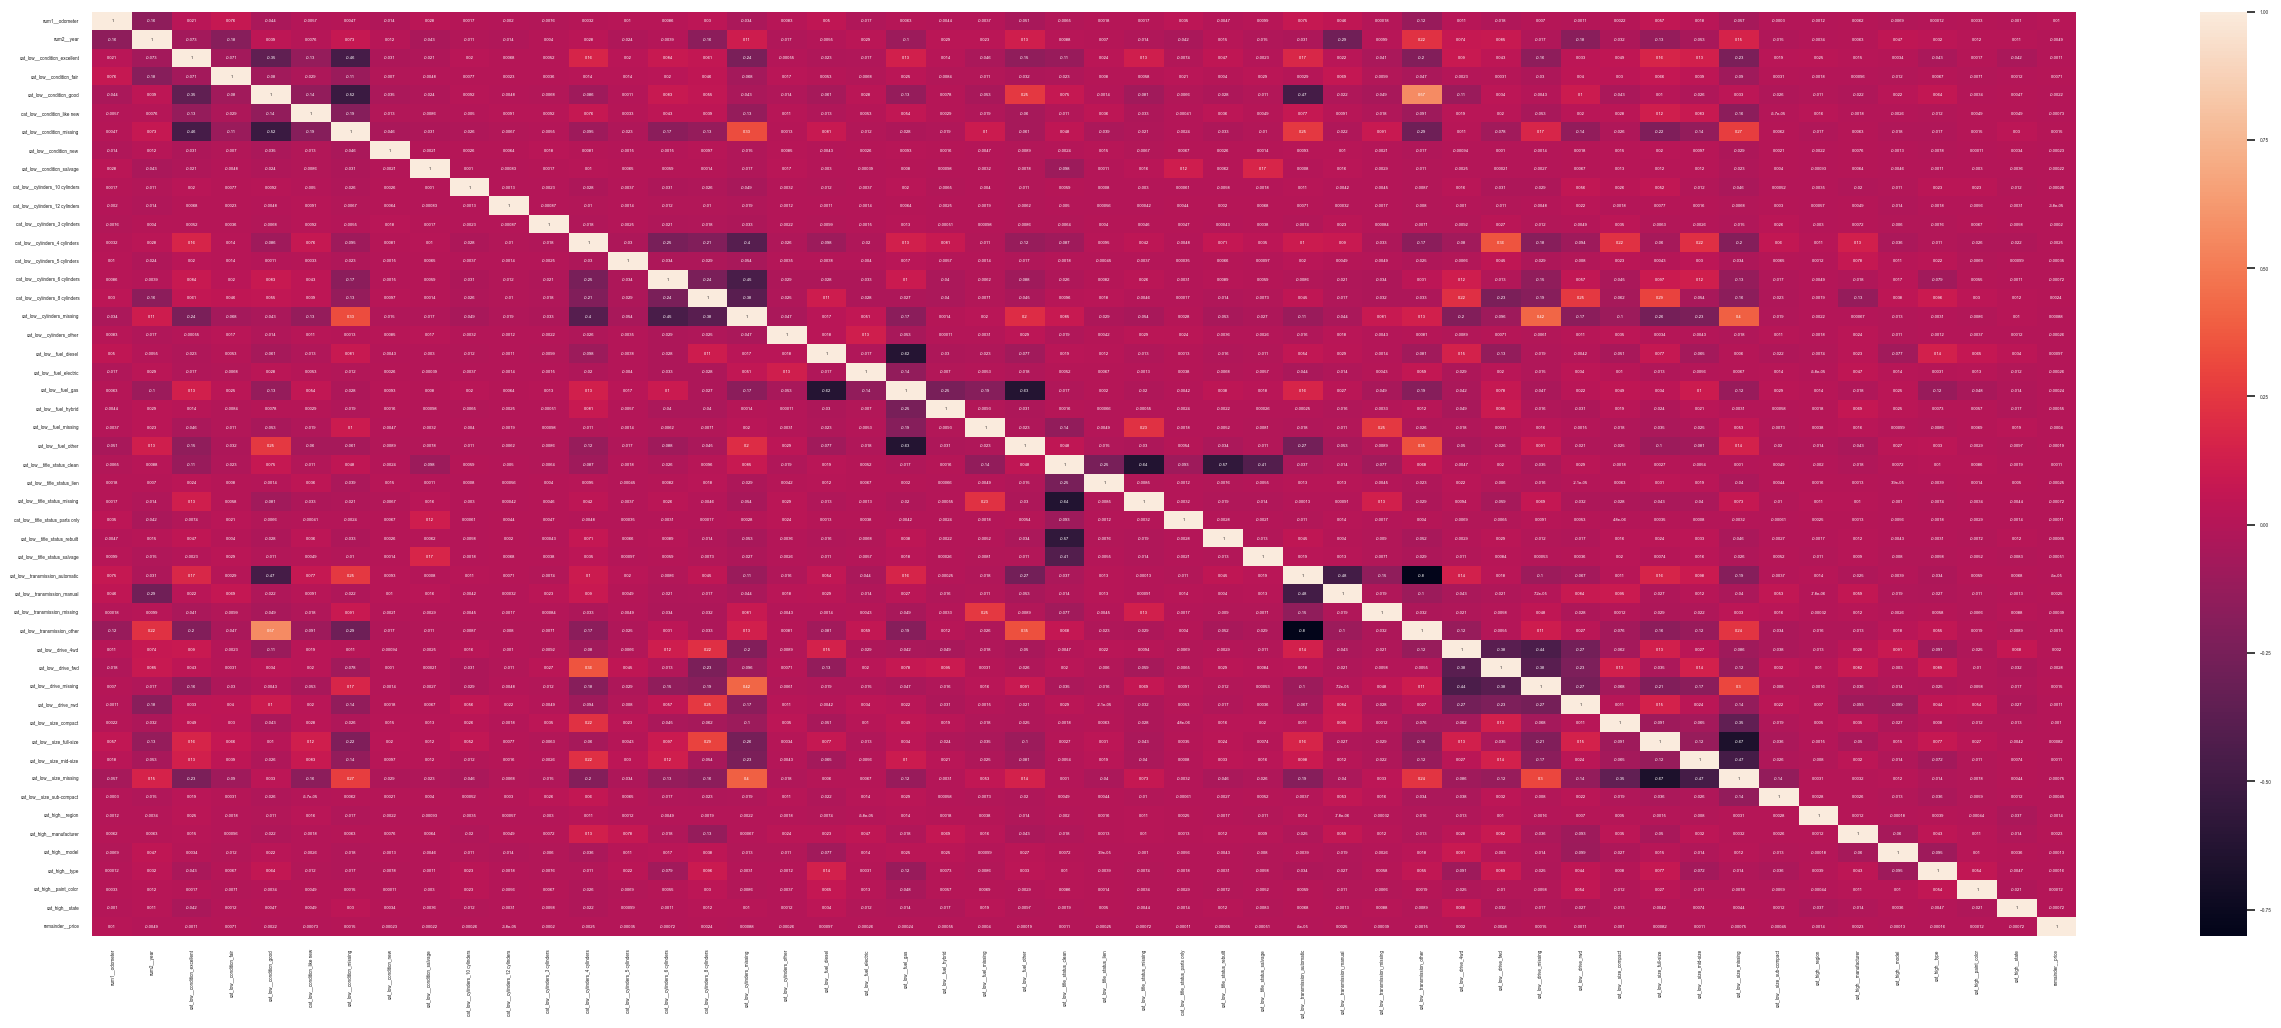

In [127]:
plt.figure(figsize=(32, 12))
sns.set(font_scale = 0.3)
sns.heatmap(df_eva.corr(), annot_kws={'size': 3},annot=True);
plt.savefig('corr_map.png', dpi=600, bbox_inches='tight')

### none of the features are strongly correlated with price, most of the features are less than .01 correlation

In [132]:
df_eva.columns

Index(['num1__odometer', 'num2__year', 'cat_low__condition_excellent',
       'cat_low__condition_fair', 'cat_low__condition_good',
       'cat_low__condition_like new', 'cat_low__condition_missing',
       'cat_low__condition_new', 'cat_low__condition_salvage',
       'cat_low__cylinders_10 cylinders', 'cat_low__cylinders_12 cylinders',
       'cat_low__cylinders_3 cylinders', 'cat_low__cylinders_4 cylinders',
       'cat_low__cylinders_5 cylinders', 'cat_low__cylinders_6 cylinders',
       'cat_low__cylinders_8 cylinders', 'cat_low__cylinders_missing',
       'cat_low__cylinders_other', 'cat_low__fuel_diesel',
       'cat_low__fuel_electric', 'cat_low__fuel_gas', 'cat_low__fuel_hybrid',
       'cat_low__fuel_missing', 'cat_low__fuel_other',
       'cat_low__title_status_clean', 'cat_low__title_status_lien',
       'cat_low__title_status_missing', 'cat_low__title_status_parts only',
       'cat_low__title_status_rebuilt', 'cat_low__title_status_salvage',
       'cat_low__transmission_

In [10]:
# split train and set set
#generate train/test data for auto

X_train, X_test, y_train, y_test = train_test_split(df_eva.drop(['remainder__price'], axis = 1), df_eva[['remainder__price']], 
                                                                       test_size = 0.3,
                                                                       random_state = 100)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [134]:
# Baseline Model
sim_linear=LinearRegression().fit(X_train, y_train)

sl_train_mse = mean_squared_error(y_train, sim_linear.predict(X_train))
sl_test_mse = mean_squared_error(y_test, sim_linear.predict(X_test))
r2=r2_score(y_test,sim_linear.predict(X_test)
            )
print('Train MSE: '+ str(sl_train_mse))
print('test MSE: '+ str(sl_test_mse))
print('test r2: '+ str(r2))

#base

Train MSE: 207605541974758.88
test MSE: 10206926171664.297
test r2: -0.006287811458300041


In [142]:
X_train.drop(cat_high_col, axis=1).head()

,num1__odometer,num2__year,cat_low__condition_excellent,cat_low__condition_fair,cat_low__condition_good,cat_low__condition_like new,cat_low__condition_missing,cat_low__condition_new,cat_low__condition_salvage,cat_low__cylinders_10 cylinders,...,cat_low__transmission_other,cat_low__drive_4wd,cat_low__drive_fwd,cat_low__drive_missing,cat_low__drive_rwd,cat_low__size_compact,cat_low__size_full-size,cat_low__size_mid-size,cat_low__size_missing,cat_low__size_sub-compact
32763,0.239485,-0.767862,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
329543,0.215093,0.185153,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
335134,0.114245,-0.344299,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
18563,-0.373944,0.820497,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
176053,-0.122398,-4.791703,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [146]:
# Taking out the high cardinal metrics and try again
# Baseline Model without high_cardinality metrics
cat_high_col=[ col for col in df_eva.columns if 'cat_high' in col]
sim_linear=LinearRegression().fit(X_train.drop(cat_high_col, axis=1),y_train)

sl_train_mse = mean_squared_error(y_train , sim_linear.predict(X_train.drop(cat_high_col, axis=1)))
sl_test_mse = mean_squared_error(y_test, sim_linear.predict(X_test.drop(cat_high_col, axis=1)))
r2=r2_score(y_test,sim_linear.predict(X_test.drop(cat_high_col, axis=1))
            )
print('Train MSE: '+ str(sl_train_mse))
print('test MSE: '+ str(sl_test_mse))
print('test r2: '+ str(r2))

#base

Train MSE: 207608276433644.75
test MSE: 10204416724328.479
test r2: -0.006040408251393181


In [31]:
# Linear regression
line_reg = Pipeline([('polyfeatures', PolynomialFeatures(degree = 2, include_bias = False)),
                    #   ('scaler', StandardScaler()),
                     ('linear', LinearRegression())])

line_reg.fit(X_train, y_train)

Pipeline(steps=[('polyfeatures', PolynomialFeatures(include_bias=False)),
                ('linear', LinearRegression())])

In [150]:
lin_train_mse = mean_squared_error(y_train, line_reg.predict(X_train))
lin_test_mse = mean_squared_error(y_test, line_reg.predict(X_test))
lin_r2=r2_score(y_test,line_reg.predict(X_test))
print('Train MSE: '+ str(lin_train_mse))
print('test MSE: '+ str(lin_test_mse))
print('test r2: '+ str(lin_r2))

Train MSE: 206527763324177.44
test MSE: 11922921741597.44
test r2: -0.17546562243668573


### best model so far is liner regression with polynomial term 2

In [10]:
## Here try lasso 
laso_pipe = Pipeline([
                    # ('polyfeatures', PolynomialFeatures(degree = 2, include_bias = False)),
                    #   ('scaler', StandardScaler()),
                     ('lasso', Lasso(random_state = 100))])
laso_pipe.fit(X_train, y_train)

lasso_mse_train = mean_squared_error(y_train, laso_pipe.predict(X_train))
lasso_mse_test = mean_squared_error(y_test, laso_pipe.predict(X_test))
lasso_r2=r2_score(y_test,laso_pipe.predict(X_test))
print('Train MSE: '+ str(lasso_mse_train))
print('test MSE: '+ str(lasso_mse_test))
print('test r2: '+ str(lasso_r2))



/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.669e+18, tolerance: 6.205e+15
  model = cd_fast.enet_coordinate_descent(


Train MSE: 207605541982710.88
test MSE: 10206920047571.586
test r2: -0.006287207691823449


In [14]:
## Here try ridge 
ridge_pipe = Pipeline([
                    ('polyfeatures', PolynomialFeatures(degree = 2, include_bias = False)),
                    #   ('scaler', StandardScaler()),
                     ('ridge', Ridge(random_state = 100))])
ridge_pipe.fit(X_train, y_train)

ridge_mse_train = mean_squared_error(y_train, ridge_pipe.predict(X_train))
ridge_mse_test = mean_squared_error(y_test, ridge_pipe.predict(X_test))
ridge_r2=r2_score(y_test,ridge_pipe.predict(X_test))
print('Train MSE: '+ str(ridge_mse_train))
print('test MSE: '+ str(ridge_mse_test))
print('test r2: '+ str(ridge_r2))

/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.42546e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train MSE: 206528677754440.94
test MSE: 11874183259054.03
test r2: -0.17066055770832889


In [24]:
## Here try ridge 
linear_lasso = Pipeline([('poly_features', PolynomialFeatures(degree = 2, include_bias = False)),
                                ('selector', SelectKBest(f_regression,
                                                                  k=20)),
                                    ('linreg', LinearRegression())])


linear_lasso.fit(X_train, y_train)

linear_lasso_train = mean_squared_error(y_train, linear_lasso.predict(X_train))
linear_lasso_test = mean_squared_error(y_test, linear_lasso.predict(X_test))
linear_lasso_r2=r2_score(y_test,linear_lasso.predict(X_test))
print('Train MSE: '+ str(linear_lasso_train))
print('test MSE: '+ str(linear_lasso_test))
print('test r2: '+ str(linear_lasso_r2))

/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train MSE: 207149001150130.44
test MSE: 10832493979278.4
test r2: -0.06796174242003628


In [29]:
# Furrther tune Ridge
ridge_param_dict_ = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_pipe = Pipeline([
                    ('polyfeatures', PolynomialFeatures(degree = 2, include_bias = False)),
                      ('selector', SelectPercentile(f_regression, percentile=20)),
                     ('ridge', Ridge(random_state = 100))])
ridge_pipe_s = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict_)
ridge_pipe_s.fit(X_train, y_train)

ridge_mse_train = mean_squared_error(y_train, ridge_pipe_s.predict(X_train))
ridge_mse_test = mean_squared_error(y_test, ridge_pipe_s.predict(X_test))
ridge_r2=r2_score(y_test,ridge_pipe_s.predict(X_test))
print('Train MSE: '+ str(ridge_mse_train))
print('test MSE: '+ str(ridge_mse_test))
print('test r2: '+ str(ridge_r2))

/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.05648e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.78295e-22): res

Train MSE: 207568346783442.5
test MSE: 10244088162360.496
test r2: -0.009951564644927968


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### After series of evluation and model comparison. The best model is the Linear regression model with polynomial term of 2 (with normalization). Again. Here is the model performance metrics: 

#### Train MSE: 206527763324177.44
#### test MSE: 11922921741597.44
#### test r2: -0.17546562243668573

In [38]:
from sklearn.inspection import permutation_importance
import random

In [47]:
len(X_test)

128064

In [50]:
ind_text=random.sample(range(len(X_test)), int(.1*len(X_test)))

In [53]:
X_test.iloc[ind_text]

,num1__odometer,num2__year,cat_low__condition_excellent,cat_low__condition_fair,cat_low__condition_good,cat_low__condition_like new,cat_low__condition_missing,cat_low__condition_new,cat_low__condition_salvage,cat_low__cylinders_10 cylinders,...,cat_low__size_full-size,cat_low__size_mid-size,cat_low__size_missing,cat_low__size_sub-compact,cat_high__region,cat_high__manufacturer,cat_high__model,cat_high__type,cat_high__paint_color,cat_high__state
414795,-0.230493,0.608716,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,225.0,41.0,21458.0,10.0,0.0,49.0
426437,0.662465,-0.450190,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,397.0,14.0,24285.0,8.0,11.0,50.0
208827,0.134266,-0.450190,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,295.0,6.0,11909.0,6.0,6.0,22.0
345824,-0.393838,0.608716,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,65.0,7.0,14034.0,11.0,11.0,40.0
35266,0.006884,0.079263,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,197.0,14.0,24340.0,9.0,11.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,0.115354,0.079263,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,8.0,0.0,19916.0,0.0,10.0,0.0
99483,0.177594,0.608716,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,158.0,13.0,14220.0,9.0,6.0,9.0
62638,-0.071151,0.079263,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,10.0,10192.0,3.0,5.0,4.0
355218,1.156881,-1.403205,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,173.0,40.0,9818.0,10.0,6.0,42.0


In [55]:
r = permutation_importance(line_reg, X_test.iloc[ind_text], y_test.iloc[ind_text],
                           n_repeats=10,
                        random_state=100)

In [67]:
perm_sorted_idx = r.importances_mean.argsort()

Text(0.5, 1.0, 'permutation_importance')

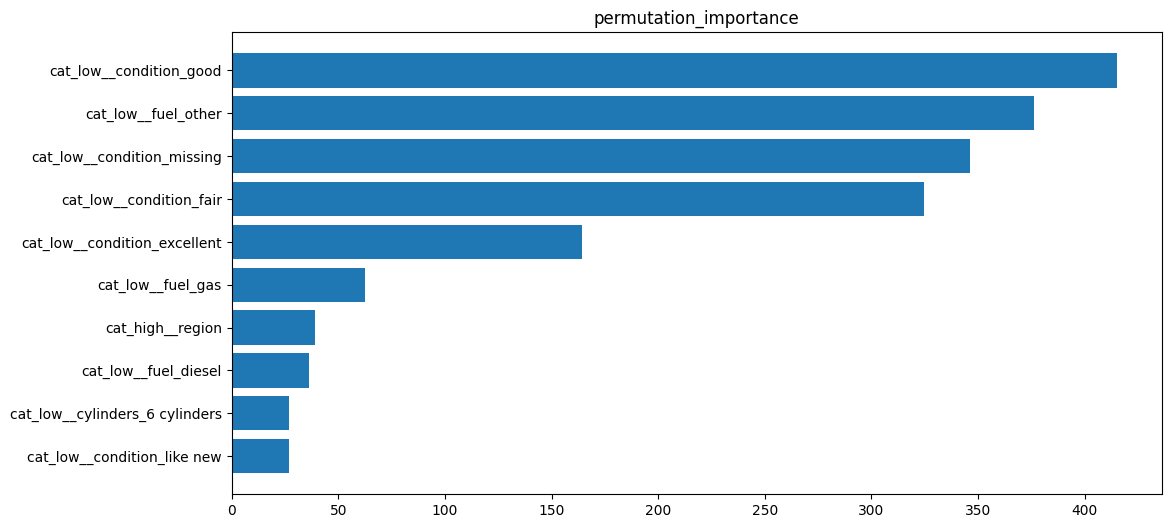

In [75]:
# Top 10 features
perm_sorted_idx = r.importances_mean.argsort()[-10:]
fig=plt.figure(figsize=(12,6))
plt.barh(range(len(perm_sorted_idx)), r.importances_mean[perm_sorted_idx], align='center')
plt.yticks(range(len(perm_sorted_idx)), np.array(X_test.columns)[perm_sorted_idx])
plt.title('permutation_importance')

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### Based on the analysis. The data contains plenty missing value during the data entry which is expected. From here, we applied a data missing value treatment depend on the type of data and the nature of the data. To avoid outlier issue, we also implemented a normalization of the value for numerical variable. For categorical features, we also applied a dummy encoding for low cardinality feature. As for high cardinality feature, we applied a ordinal encoding which is not optimal but it would suffice. We trained the data acrossed 3 different models, Linear regression, Ridge and Lasso regression with hyperparameter tunning. After all, Linear regression exhibits the best result. 

### From the feature importance, The top 10 feature are Viehcle condition , fuel type and possible cylinder that is driving the price. However, this model is still suffering from low prediction with R square equal to -0.15